# Recitation 8: Classifiers (Fall 2023)
**Date:** Friday November 3rd, 1:45pm - 3:15pm (Fagin Aud)
<br>
**Recitation TAs:** `Joseph Lee` and `Akanksha Tripathy`

Machine learning algorithms can be a powerful tool for classifying data using machine language. In this recitation, we'll discuss some commonly used Supervised Learning classification algorithms, which utilize labeled datasets to infer relationships between $X$ variables and the categorical $Y$ variable.

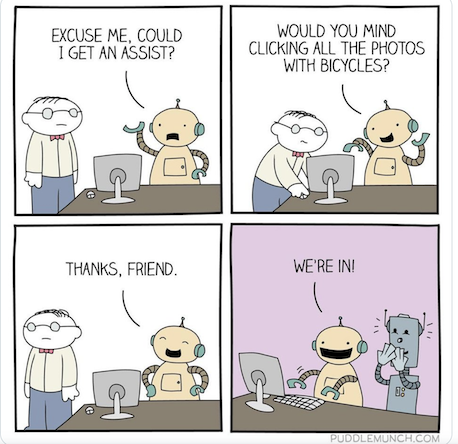

# Introduction to Supervised Learning

Supervised Learning involves training a model to make predictions. This means the model is trained using both a set of many **features** (the $\textbf{X}$) as well as a **target variable** (the $\vec{\textbf{y}}$, which is the "answer" we want to predict).

## Two Types of Supervised Learning: Regression vs. Classification

**Regression:** the target variable is within a _continuous_ range.
  - e.g. price, crop yield, etc.

**Classification:** the target variable is _categorical_.
1. _Binary Classification_ **[Our Focus]**: there are exactly 2 outcomes, typically labeled as $\{0,1\}$ or as $\{-1,+1\}$
  - e.g. churn/no churn, cancer/no cancer, yes/no, etc.
2. _Multi-Class Classification_: there are 3 or more outcomes
  - e.g. type of animal, etc.

# Setup Jargon

## Libraries and Other Jargon
- Run the following cells to set up the notebook.
- When prompted for a selection, select the number that is associated with java 8 (this should be option 2)

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns; sns.set()

from struct import unpack
import json
from datetime import datetime
from collections import Counter
import glob
import re
import os

import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
!wget -nc https://storage.googleapis.com/penn-cis545/combined_anime.csv -O anime.csv

--2023-11-01 00:57:26--  https://storage.googleapis.com/penn-cis545/combined_anime.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.251, 172.217.0.91, 172.217.12.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448845499 (428M) [text/csv]
Saving to: ‘anime.csv’

anime.csv           100%[===================>] 428.05M   162MB/s    in 2.6s    

2023-11-01 00:57:29 (162 MB/s) - ‘anime.csv’ saved [448845499/448845499]



## Dataset Cleaning and Preparation

This is **NOT** the focus of our recitation, so we've gone ahead and cleaned this data for you. Just run these cells for the purpose of our recitation.

If you want, feel free to come back here in your own time after the recitation to understand what cleaning tasks have been done. These may be quite similar to the EDA tasks you have to do in HW4!

In [ ]:
# Read original/raw data
anime_df = pd.read_csv('/content/anime.csv')

In [ ]:
# NO need to edit
# Dropping nulls and extra leftmost column
anime_df = anime_df.dropna(subset = {'anime_id', 'genre'})
anime_df = anime_df.drop(columns = ['Unnamed: 0'])

# Explode genre
anime_df['genre'] = anime_df['genre'].str.strip()
anime_df['genre'] = anime_df['genre'].str.split(',')
anime_df = anime_df.explode('genre')

# Take subset of anime_df as specified
desired_columns = ['anime_id', 'username', 'title', 'score',
                   'scored_by', 'rank', 'popularity', 'members',
                   'source', 'favorites', 'studio', 'genre']
new_anime_df = anime_df.loc[:, desired_columns]
new_anime_df = new_anime_df.dropna()
new_anime_df

# Label Encoding
from sklearn.preprocessing import LabelEncoder
le_genre = LabelEncoder()
le_genre.fit(new_anime_df['genre'])
le_studio = LabelEncoder()
le_studio.fit(new_anime_df['studio'])
le_source = LabelEncoder()
le_source.fit(new_anime_df['source'])
le_title = LabelEncoder()
le_title.fit(new_anime_df['title'])

# Add as columns to new_anime_df
new_anime_df['genre_labels'] = le_genre.transform(new_anime_df['genre'])
new_anime_df['studio_labels'] = le_studio.transform(new_anime_df['studio'])
new_anime_df['source_labels'] = le_source.transform(new_anime_df['source'])
new_anime_df['title_labels'] = le_title.transform(new_anime_df['title'])

# Create classification target variable (whether score is > mean)
mean_score = anime_df['score'].mean()
new_anime_df['above_average'] = np.where(new_anime_df['score'] > mean_score, 1.0, 0.0)

# Export cleaned file to be used later in SparkML
new_anime_df.to_csv('/content/combined_anime.csv')

#### 💡 **Discussion Point** 💡
Let's take a look at our cleaned dataframe.
1. What kind of information does the `new_anime_df` dataset here contain?
2. Do you think it makes sense to _readily_ use all the columns of this dataframe as it is to build a classification model? What problems do you foresee?

In [ ]:
new_anime_df = pd.read_csv('/content/combined_anime.csv')

In [ ]:
# Peek
new_anime_df.head()

,Unnamed: 0,anime_id,username,title,score,scored_by,rank,popularity,members,source,favorites,studio,genre,genre_labels,studio_labels,source_labels,title_labels,above_average
0,0,10020,Zukin-Man,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,7.57,83849,1435.0,658,127176,Light novel,176,AIC Build,Slice of Life,69,14,5,3724,0.0
1,0,10020,Zukin-Man,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,7.57,83849,1435.0,658,127176,Light novel,176,AIC Build,Comedy,2,14,5,3724,0.0
2,1,19111,AluPachi,Love Live! School Idol Project 2nd Season,7.99,79740,570.0,599,138715,Other,2475,Sunrise,Music,57,480,10,2864,1.0
3,1,19111,AluPachi,Love Live! School Idol Project 2nd Season,7.99,79740,570.0,599,138715,Other,2475,Sunrise,School,25,480,10,2864,1.0
4,1,19111,AluPachi,Love Live! School Idol Project 2nd Season,7.99,79740,570.0,599,138715,Other,2475,Sunrise,Slice of Life,32,480,10,2864,1.0


In [ ]:
cleaned_anime_df = new_anime_df.drop_duplicates(subset=['genre','studio','source','title','scored_by', 'popularity', 'favorites'])

In [ ]:
cleaned_anime_df.head(3)

,Unnamed: 0,anime_id,username,title,score,scored_by,rank,popularity,members,source,favorites,studio,genre,genre_labels,studio_labels,source_labels,title_labels,above_average
0,0,10020,Zukin-Man,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,7.57,83849,1435.0,658,127176,Light novel,176,AIC Build,Slice of Life,69,14,5,3724,0.0
1,0,10020,Zukin-Man,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,7.57,83849,1435.0,658,127176,Light novel,176,AIC Build,Comedy,2,14,5,3724,0.0
2,1,19111,AluPachi,Love Live! School Idol Project 2nd Season,7.99,79740,570.0,599,138715,Other,2475,Sunrise,Music,57,480,10,2864,1.0


In [ ]:
len(new_anime_df), len(new_anime_df\
                       .drop_duplicates(subset=['genre','studio','source','title',
                                                'scored_by', 'popularity', 'favorites']))

(1386393, 21460)

# Data Preprocessing: Clarifications about Standardization and Train-Test Splits

## 1. Constructing our feature dataframes ($\textbf{X}$) and label vector ($\vec{\textbf{y}}$)

In [ ]:
catgorical = ['genre', 'studio', 'source', 'title']
numerical = ['scored_by', 'popularity', 'favorites']

In [ ]:
# peek
for col in catgorical:
  print(col, Counter(cleaned_anime_df[col]).most_common()[:10])

genre [('Action', 1931), (' Comedy', 1439), ('Comedy', 1214), (' Fantasy', 1182), (' Shounen', 1114), (' Romance', 1059), (' Sci-Fi', 1024), (' Drama', 1004), (' School', 929), (' Supernatural', 801)]
studio [('Toei Animation', 1527), ('Sunrise', 1148), ('Madhouse', 997), ('J.C.Staff', 844), ('Studio Deen', 828), ('Studio Pierrot', 768), ('Production I.G', 625), ('TMS Entertainment', 574), ('A-1 Pictures', 553), ('OLM', 502)]
source [('Manga', 9396), ('Original', 5218), ('Light novel', 2059), ('Game', 1355), ('Visual novel', 992), ('Novel', 829), ('4-koma manga', 540), ('Other', 367), ('Web manga', 305), ('Card game', 131)]
title [('Ani*Kuri15', 13), ('Nihon Animator Mihonichi', 11), ('Asagiri no Miko', 11), ('Trinity Seven', 10), ('Kenpuu Denki Berserk', 10), ('InuYasha: Kanketsu-hen', 10), ('Berserk 2nd Season', 10), ('InuYasha', 10), ('Trinity Seven: Nanatsu no Taizai to Nana Madoushi', 10), ('Berserk', 10)]


In [ ]:
# consider the top 20 most popular values
for col in catgorical:
  keep_set = dict(Counter(cleaned_anime_df[col]).most_common()[:20]).keys()
  cleaned_anime_df[col] = cleaned_anime_df[col].apply(lambda x: x if x in keep_set else "Unknown")

In [ ]:
# create dummy varible for categorical columns
dummy_df = pd.get_dummies(cleaned_anime_df[catgorical])
dummy_df.shape

(21460, 78)

In [ ]:
dummy_df.head(2)

,genre_ Adventure,genre_ Comedy,genre_ Drama,genre_ Ecchi,genre_ Fantasy,genre_ Magic,genre_ Mecha,genre_ Romance,genre_ School,genre_ Sci-Fi,...,title_Kenpuu Denki Berserk,title_Macross 7,title_Mahou Sensei Negima!,title_Nihon Animator Mihonichi,title_Saber Marionette J,title_Trinity Seven,title_Trinity Seven: Nanatsu no Taizai to Nana Madoushi,title_Unknown,title_Zero no Tsukaima,title_Zero no Tsukaima: Princesses no Rondo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# features: feature dataframe, or "design matrix", or simply X - include the numeric cols and dummies
features = pd.concat([cleaned_anime_df[numerical], dummy_df], axis = 1)

# labels: our label vector, or target variable, or simply y
labels = cleaned_anime_df['above_average']

In [ ]:
# Implied columns that were dropped from the df to create the feature matrix
set(new_anime_df) - set(features)

{'Unnamed: 0',
 'above_average',
 'anime_id',
 'genre',
 'genre_labels',
 'members',
 'rank',
 'score',
 'source',
 'source_labels',
 'studio',
 'studio_labels',
 'title',
 'title_labels',
 'username'}

## 2. Split Data into Train and Test

**Rationale**
- _The Issue:_ data is scarce...yet we still need to build a model that generalizes well beyond our dataset. How then would we assess the generalizability of our model if we use the entire dataset to train it?
- _The Workaround:_ we want to **_train_** our model on a major portion of the data, but save a portion of the data so that it is "unseen" by our model so that we can **_test_** how well it does with unfamiliar data points.

**Quick Primer: Overfitting and Underfitting**
- By having training and testing sets, we can evaluate/score them independently then make a judgment about how good our model is.
  - _Underfit:_ model performs poorly on both familiar data (training) and unfamiliar/unseen data (testing)
  - _Overfit:_ model performs well on familiar data (training) but not as well on unfamiliar/unseen data (testing). This suggests that our model became too acclimated to what it was trained with and cannot generalize well.

**Implementation**

Use scikit-learn's `train_test_split` function and split data into train and test sets. We're choosing to do an 80/20 split, meaning 80% for training and the remaining 20% for testing.

To make results reproduceable, **set the random_state parameter = 42** and store the resulting splits as `x_train`, `x_test`, `y_train`, and `y_test`.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state = 42, test_size = 0.2)

In [ ]:
x_train.shape, x_test.shape

((17168, 81), (4292, 81))

## 3. Creating scaled versions of the feature dataframe

From the Unsupervised Learning module, you already saw examples of models that are _NOT_ scale-invariant and therefore need to be fed features that have been standardized.

Likewise, there are certain Supervised Learning models that require standardization for the same reason.

## ❗ **Clarification Point** ❗

In [Slide 45 of the PCA lecture](https://docs.google.com/presentation/d/16qxmRRzSKvWN_AgmA6QU0MHwhjL_l08M/edit#slide=id.p45), `StandardScaler()` was applied **_before_** the train-test split.

On the other hand, in HW4 and as you'll see in next week's Linear & Logistic Regression slides ([preview from last semester here](https://docs.google.com/presentation/d/1igQdDvMdQWDfypg3NP3W_jIhjlrp7Fm3/edit#slide=id.p43)), we do `StandardScaler` **_after_** the train-test split.


...So why is there this discrepancy? The PCA lecture was a very hand-wavy sketch of the process. At that time, Professor Ives hadn't yet talked about train and test sets so he didn't go into any detail about best practices...but now we can!

## Best Practices

We want to **standardize** `x_train` and `x_test` to have zero mean and unit variance using `x_train`'s mean and standard deviation. That's why we must instantiate a `StandardScaler()` object, then `.fit_transform()` on `x_train` but only need to transform on `x_test` using the same `StandardScaler()` object we just created.

The reason neither the scaler nor the PCA are fit again on `x_test` is because your machine learning models are trained on `x_train`. This way, when you later use these models to predict on `x_test`, the `x_test` variables will be scaled accordingly to the model's `x_train` specifications.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Instantiate object
scaler = StandardScaler()

# Learn mean and SD from training set, then standardize training set
x_train_sc = scaler.fit_transform(x_train)

# Use learned mean and SD to standardize testing set
x_test_sc = scaler.transform(x_test)

# Part 1: Worked Examples: `sklearn` Classification Models

## 1. Logistic Regression

Despite being called "regression", this is actually a classification model.

**Quick Review of Linear Regression**

Linear Regression models are of the form:

$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p$$

where the coefficients ($\beta_j$) are estimated by solving a very particular optimization problem _(minimizing the sum of squared errors)_.

#### 💡 **Discussion Point** 💡

Why can't we use linear regression to tackle a classification problem ($y \in \{0,1\}$)?

**Logistic Regression Equation**

We need a way to "squash" the standard regression output to a range $[0,1]$: the logit function!

$$\ln\left(\frac{\text{Pr}(y = 1)}{1 - \text{Pr}(y = 1)}\right) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p$$

$$\implies \text{Pr}(y = 1) = \frac{e^{\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p}}{1 + e^{\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p}}$$

Like Linear Regression, these coefficients $\beta_j$ are estimated by solving an optimization problem (which we won't get into but you'll see in lecture and can dive deeper if you take CIS 520).

Using some rounding threshold (by default 0.5 unless changed), we predict $\hat{y} = 1$ if the estimated $\text{Pr}(y = 1) \ge 0.5$, and $\hat{y} = 0$ otherwise.

**Implementation**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Instantiate L2-Regularized Logistic Regression (more in lecture next week)
logreg = LogisticRegression(penalty = "l2")

# Fit to scaled data (why?)
logreg.fit(x_train_sc, y_train)

# Predict on training and testing sets
train_pred = logreg.predict(x_train_sc)
test_pred = logreg.predict(x_test_sc)

In [ ]:
# Get Training Accuracy
logreg.score(x_train_sc, y_train)

0.8394687791239516

In [ ]:
# Get Testing Accuracy
logreg.score(x_test_sc, y_test)

0.8341099720410066

## 2. Decision Trees

**Intuition**

This is essentially a flow-chart like model with splitting rules at each node of the tree:

<img src="https://eloquentarduino.github.io/wp-content/uploads/2020/08/DecisionTree.png" width="600" height="450" />
<figcaption> Source: https://eloquentarduino.github.io/2020/10/decision-tree-random-forest-and-xgboost-on-arduino/ </figcaption>

**How does the model decide to make splits?**

Rather than giving you the answer straight up, why don't we figure it out together?

#### 💡 **Discussion Point** 💡

Consider two separate features we could potential use to split at a given node
- **Feature Candidate 1:** `creditScore` $> 750$
- **Feature Candidate 2:** `isIceCreamAddict` $= 1$

Which one do you think will give us the left picture? the right picture?

<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-26-13-13-31.png"/>
<figcaption> Source: https://www.analyticsvidhya.com/blog/2021/03/how-to-select-best-split-in-decision-trees-using-information-gain/ </figcaption>

**Key Takeaway for Intuition**

The best splitting decision among candidates is whichever feature gets us closer to _complete separation of classes_ after the split; that's the one that does a better job because we're close to achieving our goal of perfect classification!

This is formally measured / quantified through _Entropy_ and _Information Gain_, but we won't get into the Math now. See the Appendix for a more in-depth discussion.

**Pitfalls**

While very interpretable, single decision trees have a tendency to **_OVERFIT_** to the training data. So is there an improvement?

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def build_decision_tree(max_depth = None):
  # Instantiate DT with some chosen hyperparameters
  dt = DecisionTreeClassifier(random_state=0, max_depth = max_depth)

  # Fit to original data (why doesn't this have to be scaled?)
  dt.fit(x_train_sc, y_train)

  # Predict on training and testing sets
  train_pred_dt = dt.predict(x_train_sc)
  test_pred_dt = dt.predict(x_test_sc)

  print("Training Accuracy : %.4f, Testing Accuracy: %.4f"%(
    dt.score(x_train_sc, y_train), dt.score(x_test_sc, y_test)))
  return dt
dt = build_decision_tree()

Training Accuracy : 1.0000, Testing Accuracy: 0.9837


**Recall: Overfitting and Underfitting**
- By having training and testing sets, we can evaluate/score them independently then make a judgment about how good our model is.
  - _Underfit:_ model performs poorly on both familiar data (training) and unfamiliar/unseen data (testing)
  - _Overfit:_ model performs well on familiar data (training) but not as well on unfamiliar/unseen data (testing). This suggests that our model became too acclimated to what it was trained with and cannot generalize well.

**Let's decrease the complexity of the classifier and see how the performance changes**

In [ ]:
dt = build_decision_tree(max_depth = 8)

Training Accuracy : 0.8858, Testing Accuracy: 0.8749


In [ ]:
dt = build_decision_tree(max_depth = 1)

Training Accuracy : 0.8197, Testing Accuracy: 0.8159


In [ ]:
best_feature_idx = np.argmax(dt.feature_importances_)
best_feature = features.columns[best_feature_idx]
print("The %d-th feature called **%s** is the most importance feature"%(best_feature_idx, best_feature))

The 2-th feature called **favorites** is the most importance feature


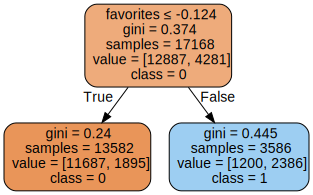

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dt, out_file=None, feature_names=x_train.columns,
                           class_names=['0', '1'], filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")
graph

In [ ]:
#######################
# feature --[Model]---> if "favorite" < threshold  -------> prediction: [0: not above average]
#                   |
#                   |
#                   --> if "favorite" >= threshold -------> prediction: [1: is above average]
########################
from sklearn.metrics import accuracy_score

def equvalent_predict(feature_data):
  return [0 if i <= -0.124 else 1 for i in feature_data[:, best_feature_idx]]

train_pred_dt = equvalent_predict(x_train_sc)
test_pred_dt = equvalent_predict(x_test_sc)

print("Training Accuracy : %.4f, Testing Accuracy: %.4f"%(
    accuracy_score(y_train, train_pred_dt), accuracy_score(y_test, test_pred_dt)))

Training Accuracy : 0.8195, Testing Accuracy: 0.8155


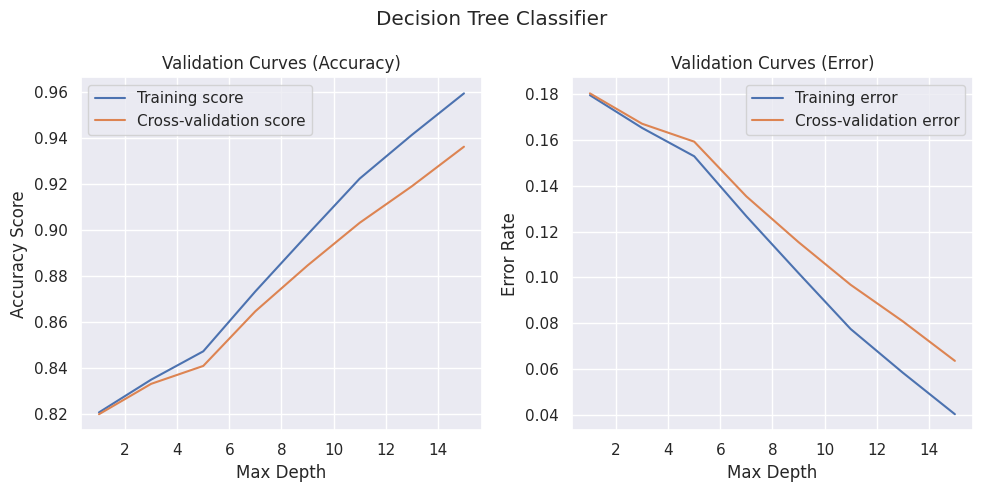

In [ ]:
# @title Validation curve: from underfitting to overfitting
from sklearn.model_selection import validation_curve
# define the hyperparameter range to explore
param_range = [1, 3, 5, 7, 9, 11, 13, 15]
clf = DecisionTreeClassifier(random_state = 0)

# generate the validation curve data
train_scores, test_scores = validation_curve(estimator=clf, X=x_train_sc, y=y_train, param_name="max_depth", param_range=param_range, cv=5)

plt.figure(figsize=(10,5))
plt.subplot(121)
# plot the validation curve
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training score")
plt.plot(param_range, np.mean(test_scores, axis=1), label="Cross-validation score")
plt.legend(loc="best")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Validation Curves (Accuracy)")

plt.subplot(122)
# plot the validation curve
plt.plot(param_range, 1-np.mean(train_scores, axis=1), label="Training error")
plt.plot(param_range, 1-np.mean(test_scores, axis=1), label="Cross-validation error")
plt.legend(loc="best")
plt.xlabel("Max Depth")
plt.ylabel("Error Rate")
plt.title("Validation Curves (Error)")
plt.suptitle("Decision Tree Classifier")
plt.tight_layout()
plt.show()

## 3. Bagged Decision Trees

**Introduction to Ensemble Models**

- This is an example of an **ensemble** model: instead of using one single decision tree, we train _many_ decision trees and aggregate their predictions to arrive at a final prediction.
- This process of "averaging" the predictions of many trees ends up covering each other's bases so we arrive at a final result that's less likely to overfit.

**What are Bagged Trees?**

- "Bagging" is actually portmanteau of "Bootstrap" and "Aggregating".
- _Bootstrap_ = create a synthetic dataset by randomly sampling observations/rows **_with_ replacement** (i.e. we could end up having the same datapoint twice)
- _Aggregation_ = the process of aggregating the predictions as outlined above.

These reduce the amount of overfitting compared to single Decision Trees, but may still overfit. Can we improve this even further?

## 4. Random Forest

**What are Random Forests?**

As the name suggests, the term "forests" refers to multiple trees while the term "random" refers to two elements
1. Random subset of observations/rows _**with**_ replacement (i.e. same as bagging).
2. Random subset of features/columns _**without**_ replacement at a given node (i.e. instead of comparing all feature candidates for a given split decision, only a subset of them is compared).

**Hence, random forest is an extension of bagging that also randomly selects subsets of features used in each data sample.**

This second element of randomness further reduces the overfitting when we aggregate the predictions of the multiple trees in the "forest".
<!--
**Implementation**

_(Note: This will take 2-3 minutes to train)_ -->

# Part 2: Worked Examples: `SparkML` Classification Models

### More SparkML Setup Jargon

Run the code below to set up Spark (you should have already installed it in the Libraries and Setup Jargon section above).

_[Note: This cell will take 3 minutes to run]_

In [ ]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pymongo
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('ml-hw4').getOrCreate()

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
import networkx as nx
import sqlite3
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

## Initializing Spark Data

We have the spark setup ready. Now we need the data for our ML algorithms. In the HW, you will do something similar and use the data you process Part I but build models in Spark.

Read in the `.csv` as a Spark dataframe (`sdf`). Make sure to set the inferSchema flag to True when you do this so that the columns are the correct datatypes and not all strings.

### Loading Spark Schema and Creating VectorAssembler

In [ ]:
# Read in the modified dataset you created (combined_anime_df.csv) instead of the original one
train_sdf = spark.read.csv('/content/combined_anime.csv', header = True, inferSchema = True, escape='\"')

In [ ]:
train_sdf.show()

+---+--------+---------------+--------------------+-----+---------+------+----------+-------+------------+---------+------------------+--------------+------------+-------------+-------------+------------+-------------+
|_c0|anime_id|       username|               title|score|scored_by|  rank|popularity|members|      source|favorites|            studio|         genre|genre_labels|studio_labels|source_labels|title_labels|above_average|
+---+--------+---------------+--------------------+-----+---------+------+----------+-------+------------+---------+------------------+--------------+------------+-------------+-------------+------------+-------------+
|  0|   10020|      Zukin-Man|Ore no Imouto ga ...| 7.57|    83849|1435.0|       658| 127176| Light novel|      176|         AIC Build| Slice of Life|          69|           14|            5|        3724|          0.0|
|  0|   10020|      Zukin-Man|Ore no Imouto ga ...| 7.57|    83849|1435.0|       658| 127176| Light novel|      176|        

Print out the Dataframe Schema and verify the datatypes.


In [ ]:
train_sdf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- username: string (nullable = true)
 |-- title: string (nullable = true)
 |-- score: double (nullable = true)
 |-- scored_by: integer (nullable = true)
 |-- rank: double (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- members: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- favorites: integer (nullable = true)
 |-- studio: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- genre_labels: integer (nullable = true)
 |-- studio_labels: integer (nullable = true)
 |-- source_labels: integer (nullable = true)
 |-- title_labels: integer (nullable = true)
 |-- above_average: double (nullable = true)



For Spark ML, we need to create a feature column which has all features concatenated and a single column for labels, which we already have!

We will use `VectorAssembler()` to create a feature vector from all categorical and numerical features and we call the final vector as “features”.

First list all columns in the data and store it in a list named `all_columns`.

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

all_columns = train_sdf.columns
all_columns

['_c0',
 'anime_id',
 'username',
 'title',
 'score',
 'scored_by',
 'rank',
 'popularity',
 'members',
 'source',
 'favorites',
 'studio',
 'genre',
 'genre_labels',
 'studio_labels',
 'source_labels',
 'title_labels',
 'above_average']

Create a list of columns which you don't want to include in your features (i.e. the original columns of labels and probably other columns which don't help the machine learning model). Name this list `drop_columns`.

In [ ]:
drop_columns = ['_c0', 'anime_id', 'username', 'score', 'above_average', 'genre', 'studio', 'source', 'title']

In [ ]:
columns_to_use = [col for col in all_columns if col not in drop_columns]
print(columns_to_use)

['scored_by', 'rank', 'popularity', 'members', 'favorites', 'genre_labels', 'studio_labels', 'source_labels', 'title_labels']


Create a VectorAssembler object with columns you want to use. Name your output column as `features` (i.e. they are the features you want to use later).

In [ ]:
assembler = VectorAssembler(inputCols = columns_to_use, outputCol = "features")

### Create Pipeline

Now we will create a pipeline with many stages. For this data, we just need a single stage with the assembler, but you could have other stages before that where you perform operations on the data like converting categorical strings in the features to numeric values, or do feature scaling operations.

In this step, we will create a pipeline with a single stage — the assembler. Fit the pipeline to your data and create the transformed dataframe and name it `modified_data_sdf`.

In [ ]:
from pyspark.ml import Pipeline

pipe  = Pipeline(stages = [assembler])
modified_data_sdf = pipe.fit(train_sdf).transform(train_sdf)

In [ ]:
modified_data_sdf.show()

+---+--------+---------------+--------------------+-----+---------+------+----------+-------+------------+---------+------------------+--------------+------------+-------------+-------------+------------+-------------+--------------------+
|_c0|anime_id|       username|               title|score|scored_by|  rank|popularity|members|      source|favorites|            studio|         genre|genre_labels|studio_labels|source_labels|title_labels|above_average|            features|
+---+--------+---------------+--------------------+-----+---------+------+----------+-------+------------+---------+------------------+--------------+------------+-------------+-------------+------------+-------------+--------------------+
|  0|   10020|      Zukin-Man|Ore no Imouto ga ...| 7.57|    83849|1435.0|       658| 127176| Light novel|      176|         AIC Build| Slice of Life|          69|           14|            5|        3724|          0.0|[83849.0,1435.0,6...|
|  0|   10020|      Zukin-Man|Ore no Imo

Now that we have the data in the format we need, we will create our train and test sets. Split into an 80-20 ratio between the train and test sets. Name these `train_sdf` and `test_sdf`

**Note:** _when you do randomSplit() please set your seed to be 24. This is because our modified_data_sdf has many many rows, and with a 0.80/0.20 split, number of rows for the split may still vary from seed to seed, but we are looking for a specific number of rows for train_sdf and test_sdf._

In [ ]:
print(modified_data_sdf.count())

1386393


In [ ]:
train_sdf, test_sdf = modified_data_sdf.randomSplit([0.8, 0.2], seed = 24)

## 1. Logistic Regression

Let's train a logistic regression model to our data and try to predict the same target variable. This time, we will use "Big" data tools. We will be using Logistic Regression first like before for classification.

This time let's **train a model without any regularization**

In [ ]:
from pyspark.ml.classification import LogisticRegression

# define the model and fit on training data
logit = LogisticRegression(featuresCol = "features", labelCol = "above_average", maxIter = 10)
logit = logit.fit(train_sdf)

Now, find out how good the model actually is and see if it overfits the training data. Predict the label for `above_average` for your test data _(HINT: it is called 'transform' in SparkML)_ and evaluate the performance using the Area Under the ROC Curve (`areaUnderROC`) metric using `BinaryClassificationEvaluator` object in the Spark ML Evaluation library.

In [ ]:
# Your code goes here
# prediction and evaluation
predictions_train = logit.transform(train_sdf)
predictions_test = logit.transform(test_sdf)

In [ ]:
predictions_train.show()

+---+--------+---------------+--------------------+-----+---------+------+----------+-------+------------+---------+--------------------+--------------+------------+-------------+-------------+------------+-------------+--------------------+--------------------+--------------------+----------+
|_c0|anime_id|       username|               title|score|scored_by|  rank|popularity|members|      source|favorites|              studio|         genre|genre_labels|studio_labels|source_labels|title_labels|above_average|            features|       rawPrediction|         probability|prediction|
+---+--------+---------------+--------------------+-----+---------+------+----------+-------+------------+---------+--------------------+--------------+------------+-------------+-------------+------------+-------------+--------------------+--------------------+--------------------+----------+
|  0|   10020|      Zukin-Man|Ore no Imouto ga ...| 7.57|    83849|1435.0|       658| 127176| Light novel|      176

In [ ]:
### Set Up BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='above_average')

# training accuracy
training_accuracy = evaluator.evaluate(predictions_train)
# Score train predictions

# performance on test data using area under roc metric
test_predictions_log =  evaluator.evaluate(predictions_test)
# Score test predictions

In [ ]:
print(training_accuracy, test_predictions_log)

0.9920241830565281 0.9919325005820858


## 2. Random Forest Classifier

We want to re-emphasize that as a data scientist, if you are looking to win Kaggle competitions, you definitely need to know about Random Forests, boosted trees, etc.

These ensemble methods generalize well and work surprisingly well for a lot of classification problems and sometimes for regression problems. So let's give it a go with our problem.

Just like the Logistic Regression model, create a random forest classifier model, fit the training data and evaluate using the area under the ROC curve metric.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Define model
rf = RandomForestClassifier(featuresCol="features", labelCol = "above_average", numTrees = 64, maxDepth = 8)

In [ ]:
# Fit on training data
rf = rf.fit(train_sdf)

In [ ]:
# Get predictions
train_predictions_rf = rf.transform(train_sdf)
test_predictions_rf = rf.transform(test_sdf)

In [ ]:
# Evaluate predictions
train_area = evaluator.evaluate(train_predictions_rf, {evaluator.metricName: "areaUnderROC"})
test_area = evaluator.evaluate(test_predictions_rf, {evaluator.metricName: "areaUnderROC"})

In [ ]:
print(train_area, test_area)

0.9994302166632704 0.9994039162764902


# Appendix: Theoretical Explanations and Additional Examples

## Decision Trees

Decision trees are an extremely intuitive way to classify or label objects: you simply ask a series of questions designed to zero in on the classification "rules".

The binary splitting makes this algorithm extremely efficient: in a well-constructed tree, each question could cut the number of split options by approximately half, very quickly narrowing down the possibilities even among a large number of features. The trick, of course, comes in deciding which questions to ask at each step. In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data; that is, each node in the tree splits the data into two groups using a cutoff value within one of the features. Let's now look at an example of this:

### Creating a Decision Tree

Consider the following two-dimensional data, which has one of four class labels:

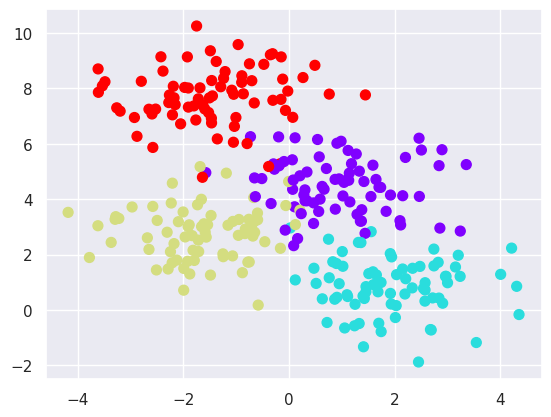

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')

A simple decision tree built on this data will iteratively split the data along one of the axes according to some quantitative criterion (usually information gain, which is discussed later).

The process of fitting a decision tree to our data can be done using scikit-learn's `DecisionTreeClassifier` estimator.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Let's write a quick utility function to help us visualize the output of the classifier

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
  ax = ax or plt.gca()

  #Plot the training points
  ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap = cmap, clim=(y.min(), y.max()), zorder=3)
  ax.axis('tight')
  ax.axis('off')
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()

  #fit the estimator
  model.fit(X, y)
  xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

  #Create a color plot with the results
  n_classes = len(np.unique(y))
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=cmap, clim=(y.min(), y.max()), zorder=1)
  ax.set(xlim=xlim, ylim=ylim)

Now we can examine the boundaries that the decision tree "drew" for us.

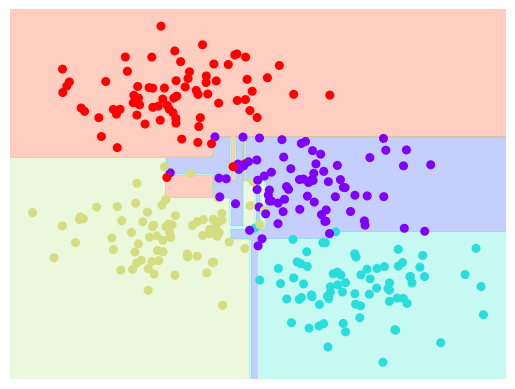

In [ ]:
visualize_classifier(DecisionTreeClassifier(), X, y)

### Entropy and Information Gain

So how exactly do decision trees determine these boundaries? We mentioned earlier that they iteratively split based on a quantitative criterion called **_information gain_** (we'll get to that in a bit).

First, it's important to understand how decision trees make use of a measure of uncertainty called **_entropy_**, which can be defined via the following formula:

$$\text{Entropy} = H(Y) = -\sum_{i=1}^n \text{Pr}(Y = y_i) \cdot \text{log}_2[ \text{Pr}(Y = y_i)]$$

In the context of a labeled dataset, $Y$ is the label variable, $n$ is the total number of classes in $Y$, and $y_i$ are the classes themselves. As a simplified example, assume we're classifying whether an animal is a dog or a cat based on some characteristics and we have the following dataframe:

In [ ]:
animal_data = pd.DataFrame({'Color': ['black', 'white', 'black', 'white', 'black'],
                            'Ears': ['pointy', 'floppy', 'pointy', 'pointy', 'floppy'],
                            'Y': ['dog', 'dog', 'cat', 'cat', 'dog']})
animal_data

,Color,Ears,Y
0,black,pointy,dog
1,white,floppy,dog
2,black,pointy,cat
3,white,pointy,cat
4,black,floppy,dog


Looking just at the $Y$ column, we can see that $\text{Pr(cat)} = 0.4$ and $\text{Pr(dog)} = 0.6$. Thus, the entropy can be calculated as follows:

$$H(Y) = -(0.4 \cdot \text{log}_2[0.4] + 0.6 \cdot \text{log}_2[0.6]) = 0.97095$$

We can also create a function to systematically compute entropy given a list or array of values:

In [ ]:
# Credit: http://gabrielelanaro.github.io/blog/2016/03/03/decision-trees.html
def entropy(s):
    res = 0
    val, counts = np.unique(s, return_counts=True)
    freqs = counts.astype('float')/len(s)
    for p in freqs:
        if p != 0.0:
            res -= p * np.log2(p)
    return res

In [ ]:
entropy(['dog', 'cat', 'cat'])

0.9182958340544896

In [ ]:
entropy(animal_data['Y'])

0.9709505944546686

which is the same answer we got from manually computing entropy earlier!

_____


Decision trees actually decide what feature to split on based on which one **minimizes entropy**, or equivalently, **maximizes information gain**.

Information gain is the **difference between the entropy of the unsplit variable and the average of the entropy of each split, weighted by the number of elements in each split.**

As its name might suggest, it essentially measures how much information is gained about the $Y$ variable given a potential split. Information gain can be defined via the following formula:

$$\text{IG}(X) = H(Y) - H(Y|X) = H(Y) - \sum_j \text{Pr}(X = x_j)\cdot H(Y|X = x_j)$$

For our simpified `animal_data` dataset, our mock decision tree only has 2 possible $X$ features to try, but usually you will have dozens if not hundreds. Let's examine how much information gain each gives us:

$$\begin{aligned}
\text{IG}(\text{Color}) &= 0.97095 - (\text{Pr}(\text{Color = 'black'}) \cdot H(Y|\text{Color = 'black'}) + \text{Pr}(\text{Color = 'white'}) \cdot H(Y|\text{Color = 'white'})) \\
&= 0.97095 - (0.6 \cdot 0.9183 + 0.4 \cdot 1)) \\
&= 0.01997
\end{aligned}$$

$$\begin{aligned}
\text{IG}(\text{Ears}) &= 0.97095 - (\text{Pr}(\text{Ears = 'floppy'}) \cdot H(Y|\text{Ears = 'floppy'}) + \text{Pr}(\text{Ears = 'pointy'}) \cdot H(Y|\text{Ears = 'pointy'})) \\
&= 0.97095 - (0.4 \cdot 0 + 0.6 \cdot 0.9183)) \\
&= 0.41997
\end{aligned}$$

Here, our decision tree will elect to split on the highest information gain possible, the `Ears` variable. Let's once again write a function to perform the computations for us:

In [ ]:
# Credit: http://gabrielelanaro.github.io/blog/2016/03/03/decision-trees.html
def information_gain(y, x):
    res = entropy(y)

    # We partition x, according to attribute values x_i
    val, counts = np.unique(x, return_counts=True)
    freqs = counts.astype('float')/len(x)

    # We calculate a weighted average of the entropy
    for p, v in zip(freqs, val):
        res -= p * entropy(y[x == v])

    return res

In [ ]:
information_gain(animal_data['Y'], animal_data['Color'])

0.01997309402197489

In [ ]:
information_gain(animal_data['Y'], animal_data['Ears'])

0.4199730940219749

We now have all the ingredients to train a decision tree! **To summarize, the general idea is as follows:**

1. Select the feature that maximizes information gain
2. Split the data using the selected feature
3. For every subset after the split, if the subset is not pure (i.e. 0 entropy, or all $Y$ are not the same), recursively split this subset by picking another feature (until you run out of features)

Note all of the above algorithms can work for numerical features as well. Those are usually handled by splitting the variable into 2 "categories" via a certain threshold (i.e. numerical values of 0.1, 0.5, 0.7 can be split into two groups, (0.1) and (0.5, 0.7), with a threshold of 0.4). The optimal threshold is, once again, selected via a split that gives maximum information gain.

## Bagged Trees and Random Forests

Random Forests are an ensemble method for decision trees, oftentimes used to combat single decision tree overfitting. \\

This notion—that multiple estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called bagging. Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification result. An ensembler of randomized decision trees is known as *random forest*. \\

This type of bagging classification can be done manually using scikit-learn's `BaggingClassifier` meta-estimator, as shown here:

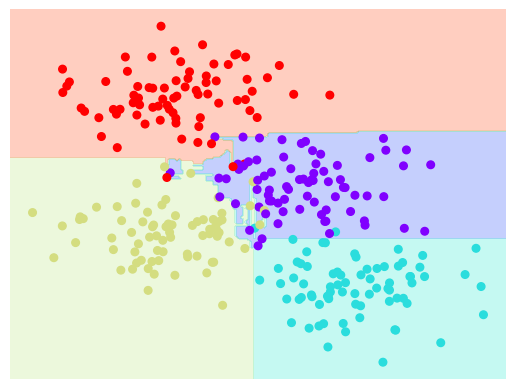

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

You may also choose to utilize the built-in `RandomForestClassifier` estimator, which returns the same results:

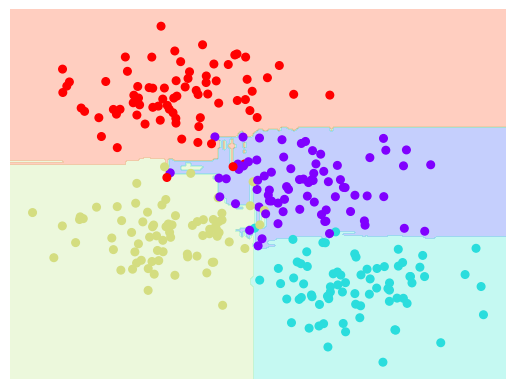

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=1)
visualize_classifier(model, X, y)

### Example: Random Forest for Classifying Digits

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

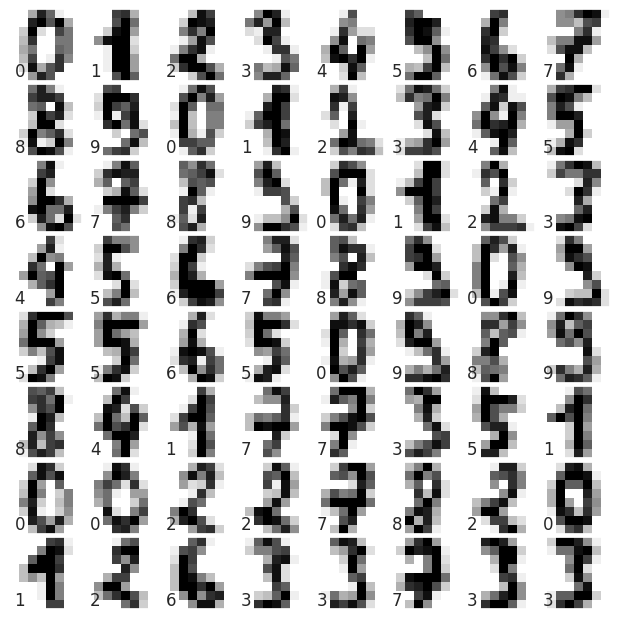

In [ ]:
#set up the figure
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

#plot the digits: each image is 8x8 pixels
for i in range(64):
  ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
  ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

  #label the image with the target value
  ax.text(0, 7, str(digits.target[i]))

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.98      1.00      0.99        43
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



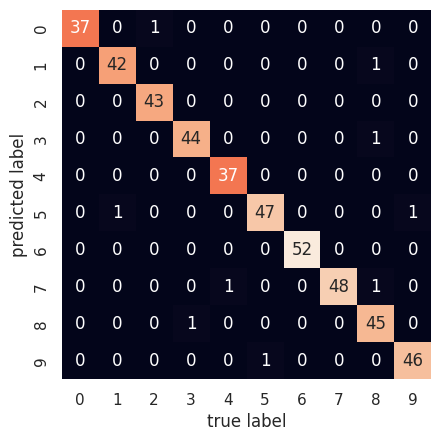

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Logistic Regression

In [ ]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2023-11-01 01:41:00--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  62.8MB/s    in 0.2s    

2023-11-01 01:41:00 (62.8 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-11-01 01:41:00--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===========

In [ ]:
#Download these from the 'data' directory, and upload them to session storage
!gzip -d train-images-idx3-ubyte.gz
!gzip -d train-labels-idx1-ubyte.gz
!gzip -d t10k-images-idx3-ubyte.gz
!gzip -d t10k-labels-idx1-ubyte.gz

In [ ]:
def loadmnist(imagefile, labelfile):
  #Open the image with gzip in read binary mode
  images = open(imagefile, 'rb')
  labels = open(labelfile, 'rb')

  #Get metadata for images
  images.read(4) #skip the magic_number
  number_of_images = images.read(4)
  number_of_images = unpack('>I', number_of_images)[0]
  rows = images.read(4)
  rows = unpack('>I', rows)[0]
  cols = images.read(4)
  cols = unpack('>I', cols)[0]

  #Get metadata for labels
  labels.read(4)
  N = labels.read(4)
  N = unpack('>I', N)[0]

  #Get data
  x = np.zeros((N, rows*cols), dtype=np.uint8) #Initialize numpy array
  y = np.zeros(N, dtype=np.uint8)
  for i in range(N):
    for j in range(rows*cols):
      tmp_pixel = images.read(1)
      tmp_pixel = unpack('>B', tmp_pixel)[0]
      x[i][j] = tmp_pixel
    tmp_label = labels.read(1)
    y[i] = unpack('>B', tmp_label)[0]

  images.close()
  labels.close()
  return (x, y)


In [ ]:
train_img, train_lbl = loadmnist('train-images-idx3-ubyte', 'train-labels-idx1-ubyte')

In [ ]:
test_img, test_lbl = loadmnist('t10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte')

In [ ]:
print(train_img.shape)

(60000, 784)


In [ ]:
print(train_lbl.shape)

(60000,)


In [ ]:
print(test_img.shape)

(10000, 784)


In [ ]:
print(test_lbl.shape)

(10000,)


### Showing Training Digits and Labels

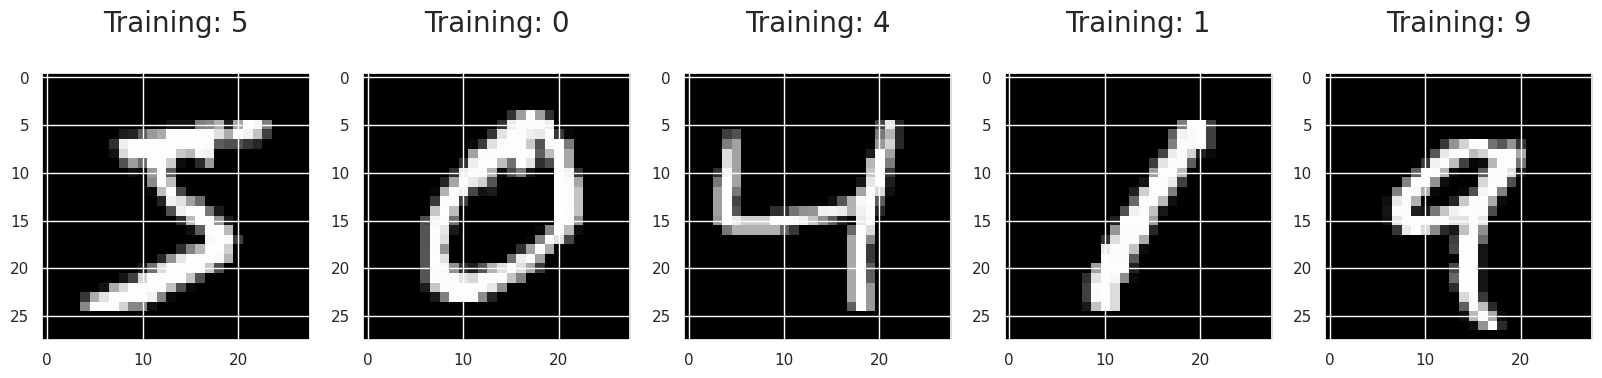

In [ ]:
plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(train_img[0:5], train_lbl[0:5])):
  plt.subplot(1, 5, index + 1)
  plt.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray)
  plt.title('Training: %i\n' % label, fontsize = 20)

In [ ]:
#This is how the computer sees the number 5
print(train_img[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

### Using Logistic Regression on Entire Dataset

[Logistic Regression sklearn documentation
](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) \\

Parameter tuning is very important! While it may not have mattered much for the toy digits dataset, it can make a major difference on larger and more complex datasets you have. Please see the paramter: solver

In sklearn, all machine learning models are implemented as Python classes

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# all parameters not specified are set to their defaults
#default solver is incredibly slow that's why we change it
logisticRegr = LogisticRegression(solver = 'lbfgs')

In [ ]:
logisticRegr.fit(train_img, train_lbl)

LogisticRegression()

Uses the information the model learned during the model training process

In [ ]:
logisticRegr.predict(test_img[0:10])

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9], dtype=uint8)

## Measuring Model Performance

$$\text{Accuracy = fraction of correct predictions =} \frac{\text{Number of correct predictions}}{\text{Total number of data points}}$$

Basically, how the model performs on new data (test set)

In [ ]:
score = logisticRegr.score(test_img, test_lbl)
print(score)

0.9255


### Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or a "classifier") on a set of test data for which the true values are known.

In [ ]:
predictions = logisticRegr.predict(test_img)

In [ ]:
cm = metrics.confusion_matrix(test_lbl, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

Text(0.5, 1.0, 'Accuracy Score: 0.925')

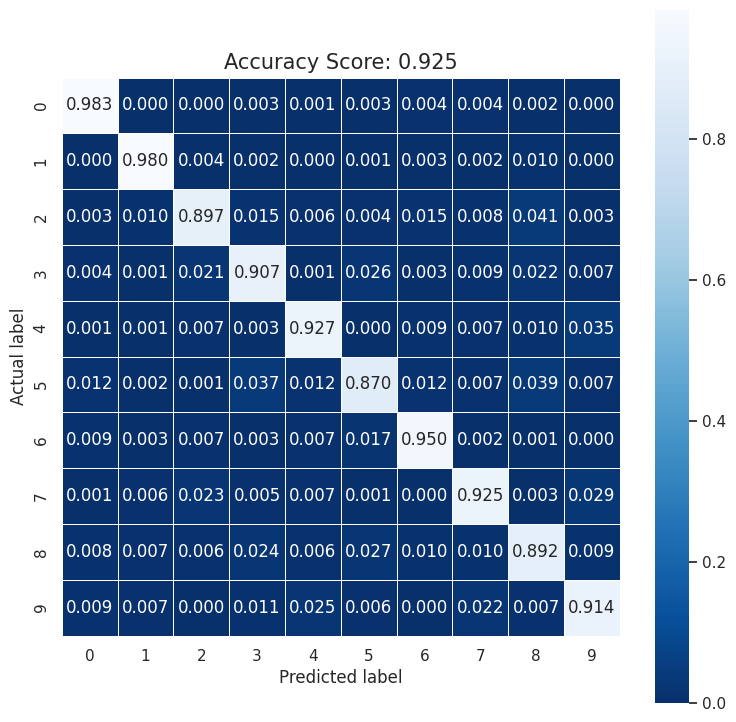

In [ ]:
plt.figure(figsize=(9, 9))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidth=.5, square=True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {:.3f}'.format(score)
plt.title(all_sample_title, size = 15)

### Display Misclassified Images with Predicted Labels

In [ ]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(test_lbl, predictions):
  if label != predict:
    misclassifiedIndexes.append(index)
  index += 1

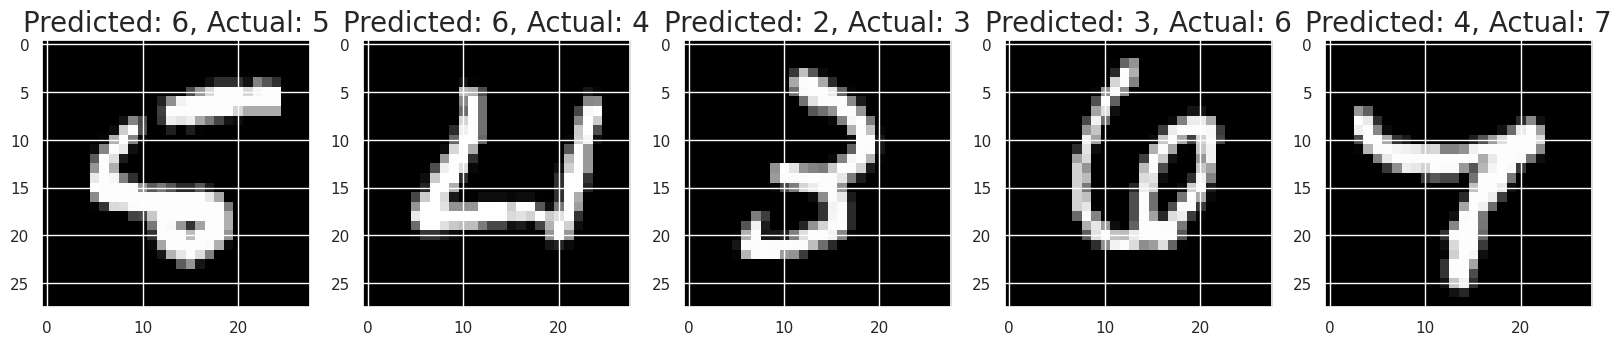

In [ ]:
plt.figure(figsize=(20, 4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
  plt.subplot(1, 5, plotIndex + 1)
  plt.imshow(np.reshape(test_img[badIndex], (28, 28)), cmap=plt.cm.gray)
  plt.title('Predicted: {}, Actual: {}'.format(predictions[badIndex], test_lbl[badIndex]), fontsize= 20)